#%load_ext autoreload
#%autoreload 2

In [1]:
from theta.rtbm import RTBM
from theta.mathtools import normalization_consistency
import numpy as np
import copy
import pathlib
from time import time
from cma import CMAEvolutionStrategy
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 4]

In [2]:
ndim = 2
nhid = 3
nevt = 1e4
rtbm = RTBM(ndim, nhid, 
            minimization_bound=50,
            gaussian_init=True,
            positive_T=True, 
            positive_Q=True,
            gaussian_parameters = {"mean" : 0.0, "std": 0.55},
            sampling_activation = "tanh"
           )
params_0 = copy.deepcopy(rtbm.get_parameters())

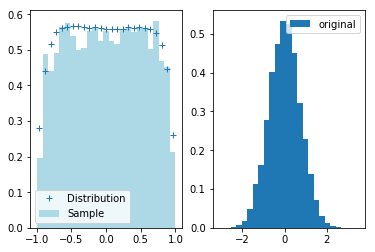

In [3]:
d = 0

def reorder(x, y, z):
    """ Return x, y, z as arrays ordered by x """
    r123 = np.array([ i for i in sorted(zip(x,y,z)) ]).T
    return r123

def get_values(n=nevt):
    xrand, xjac, original_r = rtbm.make_sample_rho(n)
    res = []
    for dimension in range(ndim):
        res.append( reorder(xrand[:,dimension], xjac, original_r[:,dimension]) )
    return np.stack(res, axis=1)

def plot_distribution(x, yvals, nbins=20, initial_val=-1, final_val=1, fmt='+', label="Distribution"):
    if ndim == 1:
        return plt.plot(x, yvals, label=label)
    else:
        step = (final_val - initial_val)/nbins

        bin_walls = np.arange(initial_val, final_val, step=step)
        idx = np.digitize(x, bin_walls, right=False)-1
        
        # Bin the result
        res = np.bincount(idx, weights=yvals, minlength=nbins)
        # Normalize
        res /= np.bincount(idx, minlength=nbins)/ndim
        return plt.plot(bin_walls+step/2, res, fmt, label=label)

x_pre, y_pre_total, ordered_r = get_values()
y_pre = y_pre_total[0] # y ordenado según la primera dimension de x_pre
        
plt.subplot(1,2,1)
plt.hist(x_pre[d], bins=25, density=True, color="lightblue", label="Sample")
plot_distribution(x_pre[d], y_pre, nbins=25)
#plt.plot(x_pre[d], y_pre, label="Distribution")
_ = plt.legend()
plt.subplot(1,2,2)
plt.hist(ordered_r[d], bins=25, density=True, label="original")
_ = plt.legend()

Total loss: 3446.20


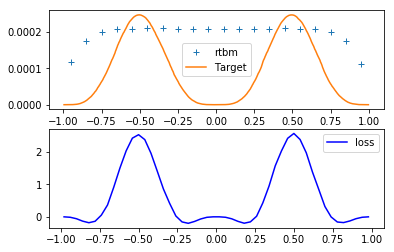

In [4]:
def my_fun(xarr):
    res = np.abs(pow(np.sin(np.pi*xarr), 2))
    # res = 2.0*xarr**2 + xarr - 3.0*xarr**3 + 0.5
    return np.prod(res, axis=0)

def kl(x, ytarget):
    return ytarget*np.log(ytarget/x)

def mse(x, y):
    return (x-y)**2

def labs(x,y):
    return np.abs(x-y)

lfun = kl

def loss(x,y):
    norm_x = np.sum(x)
    norm_y = np.sum(y)
    return lfun(x, y)
    return kl(x/norm_x, y/norm_y)*nevt#/(x+y)*nevt

my_y = my_fun(x_pre)
ll = loss(y_pre, my_y)

plt.subplot(2,1,1)
# plt.plot(x_pre, y_pre/np.sum(y_pre), label="rtbm")
plot_distribution(x_pre[d], y_pre/np.sum(y_pre), label="rtbm")
plt.plot(x_pre[d], my_y/np.sum(my_y), label = "Target")
_ = plt.legend()
plt.subplot(2,1,2)
# plt.plot(x_pre[d], ll, label="loss")
plot_distribution(x_pre[d], ll, nbins = 50, fmt='b-', label="loss")
_ = plt.legend()
print(f"Total loss: {np.sum(ll):.2f}")

Starting loss: 3281.61
Iteration: 0, best loss: 1925.12, time: 2.16s
Iteration: 50, best loss: -3601.30, time: 232.99s
Iteration: 100, best loss: -3924.49, time: 375.64s
Iteration: 150, best loss: -4087.18, time: 393.25s
Iteration: 200, best loss: -4209.92, time: 409.01s
Iteration: 250, best loss: -4302.39, time: 427.14s
Iteration: 300, best loss: -4377.91, time: 442.53s
Iteration: 350, best loss: -4446.27, time: 466.66s
Iteration: 400, best loss: -4503.81, time: 477.00s
Iteration: 450, best loss: -4562.60, time: 483.34s
Iteration: 500, best loss: -4617.26, time: 492.37s
Resetting sigma, with loss: -4638.83

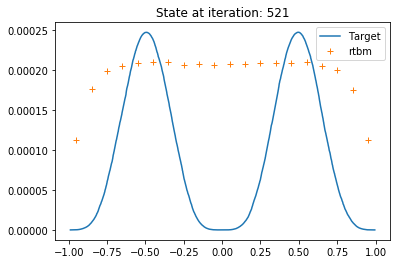

 new loss: -4622.47
Iteration: 550, best loss: -4647.29, time: 488.81s
Resetting sigma, with loss: -4689.29

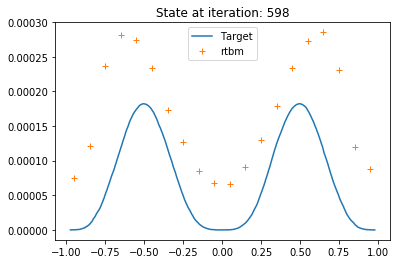

 new loss: -6098.73
Iteration: 600, best loss: -6098.73, time: 532.21s
Iteration: 650, best loss: -6245.83, time: 557.82s
Iteration: 700, best loss: -6309.68, time: 572.24s
Resetting sigma, with loss: -6326.94

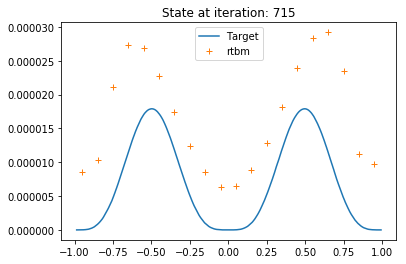

 new loss: -63875.31
Iteration: 750, best loss: -64349.47, time: 3368.66s
Resetting sigma, with loss: -64687.92

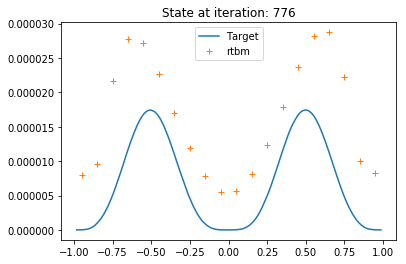

 new loss: -66250.58
Iteration: 800, best loss: -66852.75, time: 4953.66s
Iteration: 850, best loss: -67447.30, time: 5093.33s
Resetting sigma, with loss: -67678.09

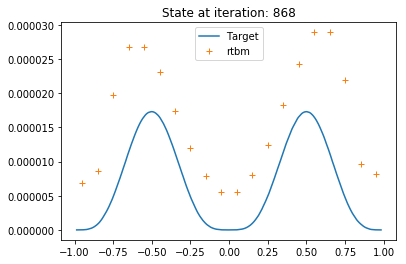

 new loss: -67842.20
Resetting sigma, with loss: -68369.81

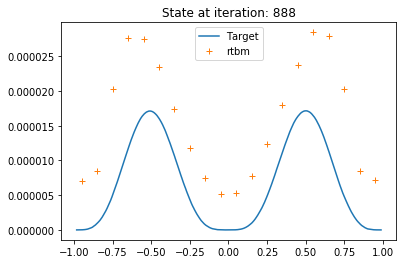

 new loss: -68903.30
No more repeats allowed, iteration: 888, loss: -68903.29722453163


In [5]:
def generate_loss(xinput):

    def target_loss(params):
        if not rtbm.set_parameters(params):
            return np.NaN
        new_x, prob = rtbm.get_transformation(xinput.T) # tiene que entrar como (events, dimensions)
        y = my_fun(new_x.T) # sin embargo aquí lo queremos como (dimensions, events)
        return np.sum(loss(prob, y))
    
    return target_loss

# GA parameters
iterations = 3000
original_sigma = 0.25
sigma = original_sigma
epsilon = 1e-3
mutation_rates = np.array([0.2, 0.4, 0.6, 0.8])
population_per_rate = 128
rates = np.concatenate([np.ones(population_per_rate)*mr for mr in mutation_rates])
ss = len(params_0)

min_bound, max_bound = rtbm.get_bounds()
repeats = 6

with Parallel(n_jobs=16) as parallel:
    
    best_parameters = params_0
    prev = time()
    
    x_input = ordered_r
    target_loss = generate_loss(x_input)
    loss_val = target_loss(best_parameters)
    print(f"Starting loss: {loss_val:.2f}")
    
    for it in range(iterations):
        
        p0 = copy.deepcopy(best_parameters)
        
        def compute_mutant(mrate):
            nm = int(ss*mrate)
            mut_idx = np.random.choice(ss, nm, replace=False)
            r1, r2 = np.random.rand(2, nm)*sigma

            mutant = copy.deepcopy(p0)
            var_plus = max_bound - p0
            var_minus = min_bound - p0
            mutant[mut_idx] += var_plus[mut_idx]*r1 + var_minus[mut_idx]*r2
            
            return target_loss(mutant), mutant
    
        parallel_runs = [delayed(compute_mutant)(rate) for rate in rates]
        result = parallel(parallel_runs)
        losses, mutants = zip(*result)
        
        best_loss = np.nanmin(losses)
        if best_loss < loss_val:
            loss_val = best_loss
            best_parameters = mutants[losses.index(best_loss)]
        else:
            sigma /= 2
            
        if it % 50 == 0:
            current = time()
            print(f"Iteration: {it}, best loss: {loss_val:.2f}, time: {current-prev:.2f}s")
            prev = current
            
        if sigma < epsilon:
            sigma = original_sigma
            print(f"Resetting sigma, with loss: {loss_val:.2f}", end="")
            repeats -= 1
            #break
            
            if repeats == 3:
                nevt *= 10
                
            previous_best = copy.deepcopy(rtbm.get_parameters())
            
            # Every time we reset, let's plot what we have!
            x_tmp, y_tmp_all, x_input = get_values(n=nevt)
            y_tmp = y_tmp_all[d]
            my_tmp = my_fun(x_tmp)

            plt.plot(x_tmp[d], my_tmp/np.sum(my_tmp), label = "Target")
            plot_distribution(x_tmp[d], y_tmp/np.sum(y_tmp), label = "rtbm")
            
            plt.title(f"State at iteration: {it}")
            plt.legend()
            plt.show()
            #

            target_loss = generate_loss(x_input)
            loss_val = target_loss(best_parameters)
            if np.isnan(loss_val):
                import pdb
                pdb.set_trace()
            print(f" new loss: {loss_val:.2f}")
            
        
        if not repeats:
            print(f"No more repeats allowed, iteration: {it}, loss: {loss_val}")
            break
    rtbm.set_parameters(best_parameters)

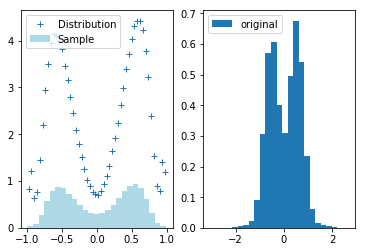

In [6]:
x_post, y_post_all, ordered_post = get_values(n=nevt)
y_post = y_post_all[d]
#x_raw, y_raw = rtbm.get_transformation(x_input.reshape(-1,1))
#x_post, y_post, ordered_post = reorder(x_raw[:,d], y_raw, x_input)


plt.subplot(1,2,1)
plt.hist(x_post[d], bins=25, density=True, color="lightblue", label="Sample")
plot_distribution(x_post[d], y_post, nbins=50)
# plt.plot(x_post, y_post, label="Distribution")
_ = plt.legend()
plt.subplot(1,2,2)
plt.hist(ordered_post[d], bins=25, density=True, label="original")
_ = plt.legend()

Total loss: 3446.199050439555


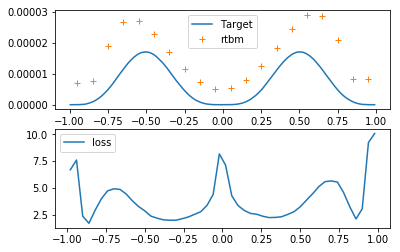

In [7]:
my_y_post = my_fun(x_post)
ll_post = loss(my_y_post, y_post)


plt.subplot(2,1,1)
plt.plot(x_post[d], my_y_post/np.sum(my_y_post), label = "Target")
plot_distribution(x_post[d], y_post/np.sum(y_post), label = "rtbm")
# plt.plot(x_pre, y_pre/np.sum(y_pre), label="RTBM old")
#plot_distribution(x_pre[d], y_pre/np.sum(y_pre), label="RTBM old")

_ = plt.legend()
plt.subplot(2,1,2)
# plt.plot(x_post, ll_post, label="loss")
plot_distribution(x_post[d], ll_post, label="loss", fmt="-", nbins=50)
_ = plt.legend()
name_fig=pathlib.Path(f"good_fit_nh={nhid}_loss={lfun.__name__}_nv={ndim}.png")
if name_fig.exists():
    print("WARNING: Image not saved, it already existed")
else:
    plt.savefig(str(name_fig))
    print(f"Image saved at {name_fig}")
print(f"Total loss: {np.sum(ll)}")

# Notas:

- Cuando usamos `minmax`, estamos cambiando, cada vez que entrenamos, el rango de acción. Por tanto, para entrenar con minmax tendríamos que generar datos en cada step o definir desde el principio donde están el máximo y el mínimo. ¿Se puede hacer esto? ¿Podemos controlar con los boundaries dónde están el máximo y el mínimo?
- Cuando usamos `sigmoid` o `tanh` el entrenamiento funciona fatal. ¿Podemos encontrar alguna forma mejor de hacerlo?
- Con `tanh`, de todas formas, logramos mejor entrenamiento que con `sigmoid`. _At the end of the day_ el único punto relevante es que los límites de integración sean 1) fijos 2) finitos así que so far so good. Seguramente `sigmoid` sea igualmente bueno pero el estado inicial puede ser más important. Con `nh=2` obtenemos un buen fit para el seno (4 picos).
- No estoy seguro de por qué no está corriendo todo lo en paralelo que podría? Me confunde que a veces lo haga sin embargo. Claramente hay un problema con `joblib` y `jupyter` que quizá esté relacionado con el uso de `autoreload`. Probemos a comentarlo: el problema persiste. Quizá sea el momento de probar otra librería de paralelización.
- Llegamos a entrenar bastante bien las partes más importantes, quizá es hora de aumentar el número de eventos.
- IMPORTANTE: a veces los samples que obtenemos no se corresponden al 100% con la función de probabilidad que (en teoría) estamos calculando. Puede que haya un missmatch o error en la transformación? (if so, por qué entrena tan bien)
- Para dimensiones mayores a 1 parece que abs/mse no funciona bien así que he probado con KL y parece ir bien. El fit no es perfecto pero no necesitamos que lo sea.
- Hay que tener mucho cuidado al entrenar una vez que empezamos a samplear de la rtbm...

#### 